In [9]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from athletes_brain.fig2.config import GROUP_NAMES

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update(
    {
        # ── Canvas size & resolution ───────────────────────────────────────────
        # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
        "figure.figsize": (12, 8),
        "figure.dpi": 200,  # crisp in-notebook / retina preview
        "savefig.dpi": 400,  # print-quality PNG/PDF
        # ── Fonts ──────────────────────────────────────────────────────────────
        "font.family": "sans-serif",
        "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
        "axes.titlesize": 24,
        # "axes.titleweight": "bold",
        "axes.labelsize": 24,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 20,
        # ── Axis & spine aesthetics ────────────────────────────────────────────
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.linewidth": 1,
        "axes.grid": True,
        "grid.color": "#E6E6E6",
        "grid.linewidth": 0.4,
        "grid.alpha": 0.8,
        # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
        "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),
        # ── Figure background ─────────────────────────────────────────────────
        "figure.facecolor": "white",
    }
)

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",  # slightly larger fonts for presentations / papers
    style="whitegrid",  # grid only on y-axis (good for histograms)
    palette="Set2",  # matches the rcParams colour cycle
)


# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True, **savefig_kwargs)


# 4.  Colour constants for this project (optional convenience)
COL_RAW = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF = "0.35"  # census reference (neutral grey)

In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/athletes_brain/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/athletes_brain/figures/fig2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" / "atlases" / ATLAS / "parcels.csv", index_col=0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [4]:
metrics = ["gm_vol", "wm_vol", "csf_vol", "adc", "fa", "ad", "rd"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
        drop=True
    )
    # data[metric] = data[metric].drop_duplicates(subset=["subject_code", region_col], keep="last")
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})


# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_2417477/1396018435.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_2417477/1396018435.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_2417477/1396018435.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_2417477/1396018435.py:9: DtypeWarning: Columns (16,23,24,25,26,27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0

In [5]:
metric_cols = {metric: "volume" if "vol" in metric else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df

In [6]:
import pandas as pd
import numpy as np
from functools import reduce

# Assuming 'region_col' is defined globally (e.g., 'Region_Name' or 'Region_ID')
# Make sure to define it if not already:
# region_col = 'Region_ID' # Example, adapt to your actual region column name


# --- Adapted `long_to_wide` Function ---
def long_to_wide(
    long_df,
    *,
    index_cols=["subject_code", "session_id"],  # Use both for unique sessions
    columns_to_pivot=region_col,  # Your region column name
    values_col="value",
    demographic_cols=[
        "age_at_scan",
        "sex",
        "group",
        "target",
        "tiv",
    ],  # Include all relevant demographics/targets
):
    """
    Pivots a long metric table to a wide DataFrame (sessions x features),
    while preserving demographic and target columns.

    Parameters
    ----------
    long_df : pd.DataFrame
        Input DataFrame in long format with columns like index_cols, columns_to_pivot,
        values_col, and demographic_cols.
    index_cols : list of str
        Columns to use as the index for pivoting (e.g., ['Participant_ID', 'Session_ID']).
    columns_to_pivot : str
        Column containing the region names/IDs to become new columns.
    values_col : str
        Column containing the metric values.
    demographic_cols : list of str
        Other columns to preserve (demographics, target variables).

    Returns
    -------
    pd.DataFrame
        Wide-format DataFrame with (Participant_ID, Session_ID) as a multi-index,
        region values as columns (prefixed with metric type), and
        demographic/target columns.
    """
    # Ensure all index_cols and demographic_cols are in the DataFrame
    if not all(col in long_df.columns for col in index_cols + [columns_to_pivot, values_col]):
        raise ValueError(
            f"Missing essential columns for pivoting. Required: {index_cols + [columns_to_pivot, values_col]}"
        )

    # Filter demographic_cols to only those actually present in the long_df
    present_demographic_cols = [col for col in demographic_cols if col in long_df.columns]

    # Handle multiple sessions per participant if Session_ID is not explicit
    if "session_id" not in long_df.columns:
        long_df["session_id"] = long_df.groupby("Participant_ID").cumcount() + 1
        print(
            "  Warning: 'Session_ID' not found in long_df. Generated dummy Session_ID for pivoting."
        )

    # Select columns to pivot and drop duplicates for the index/demographics
    # We drop duplicates to ensure only one set of demographic/target data per session
    meta_df = long_df[index_cols + present_demographic_cols].drop_duplicates(subset=index_cols)
    meta_df = meta_df.set_index(index_cols)

    # Pivot the metric data
    wide_metric = long_df.pivot_table(
        index=index_cols, columns=columns_to_pivot, values=values_col
    )

    # Merge demographics back. Ensure column names from wide_metric are unique.
    # The columns from wide_metric are already the region names, no prefix needed here yet.
    full_wide_df = meta_df.join(
        wide_metric, how="inner"
    )  # Inner join to ensure only sessions with metric data

    # Optional: Missing value thresholding
    # These thresholds might need careful consideration in a multimodal context
    # as dropping columns from one metric might affect others later.
    # For initial combined ML, it's often better to drop NaNs at the end on the full feature set.
    # You can re-enable if you want to filter per-metric-wise first.
    # thresh_cols = int(0.8 * len(full_wide_df))
    # full_wide_df = full_wide_df.dropna(axis=1, thresh=thresh_cols)
    # thresh_rows = int(0.8 * len(wide_metric.columns)) # Assuming parcels is wide_metric.columns
    # full_wide_df = full_wide_df.dropna(axis=0, thresh=thresh_rows)

    return full_wide_df.reset_index()

In [7]:
common_sessions = []
data_wide = {}
for metric, df in data.items():
    data_wide[metric] = long_to_wide(df)
    common_sessions.append(set(data_wide[metric]["session_id"].unique()))
# Find common sessions across all metrics
common_sessions = reduce(lambda x, y: x.intersection(y), common_sessions)
# Filter each metric DataFrame to only include common sessions
for metric in data_wide:
    data_wide[metric] = data_wide[metric][data_wide[metric]["session_id"].isin(common_sessions)]




In [79]:
import ast  # Import the Abstract Syntax Tree module


def _convert_permutation_scores_string_to_array(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the 'permutation_scores' column from string representation of an array
    back into a NumPy array.
    """
    if "permutation_scores" in df.columns:
        # Check if the column is of string type and needs conversion
        if df["permutation_scores"].apply(lambda x: isinstance(x, str)).any():
            # print("Converting 'permutation_scores' column from string to NumPy array...")
            # Use ast.literal_eval to safely parse the string as a Python literal (list or array string)
            # Then convert to NumPy array. Handle potential newline characters.
            df["permutation_scores"] = df["permutation_scores"].apply(
                lambda x: (
                    np.array(ast.literal_eval(x.replace("\n", " ").replace(" ", ", 0")))
                    if isinstance(x, str)
                    else x
                )
            )
    return df

In [281]:
best_models = {}
predictions = {}
results = {}



for group, group_name in GROUP_NAMES.items():
    print(f"Processing group: {group_name}")
    best_models[group_name] = {}
    predictions[group_name] = {}
    results[group_name] = {}
    for metric in metrics + ["stacked"]:
        print(f"  Metric: {metric}")
        # load the best model for this group and metric
        model_path = (OUTPUT_DIR / group_name / metric / "best_model.pkl").resolve()
        if not model_path.exists():
            print(f"    No model found for {group_name} - {metric}, skipping.")
            continue
        best_models[group_name][metric] = pd.read_pickle(model_path)
        # load the predictions for this group and metric
        predictions_path = (OUTPUT_DIR / group_name / metric / "predictions.csv").resolve()
        if not predictions_path.exists():
            print(f"    No predictions found for {group_name} - {metric}, skipping.")
            continue
        predictions[group_name][metric] = pd.read_csv(predictions_path, index_col=0)
        # load the results for this group and metric
        results_path = (OUTPUT_DIR / group_name / metric / "results.csv").resolve()
        if not results_path.exists():
            print(f"    No results found for {group_name} - {metric}, skipping.")
            continue
        results[group_name][metric] = _convert_permutation_scores_string_to_array(pd.read_csv(results_path, index_col=0))
    
# load stacked

Processing group: all
  Metric: gm_vol
  Metric: wm_vol
  Metric: csf_vol
  Metric: adc
  Metric: fa
  Metric: ad
  Metric: rd
  Metric: stacked
Processing group: climbing
  Metric: gm_vol
  Metric: wm_vol
  Metric: csf_vol
  Metric: adc
  Metric: fa
  Metric: ad
  Metric: rd
  Metric: stacked
Processing group: bjj
  Metric: gm_vol
  Metric: wm_vol
  Metric: csf_vol
  Metric: adc
  Metric: fa
  Metric: ad
  Metric: rd
  Metric: stacked


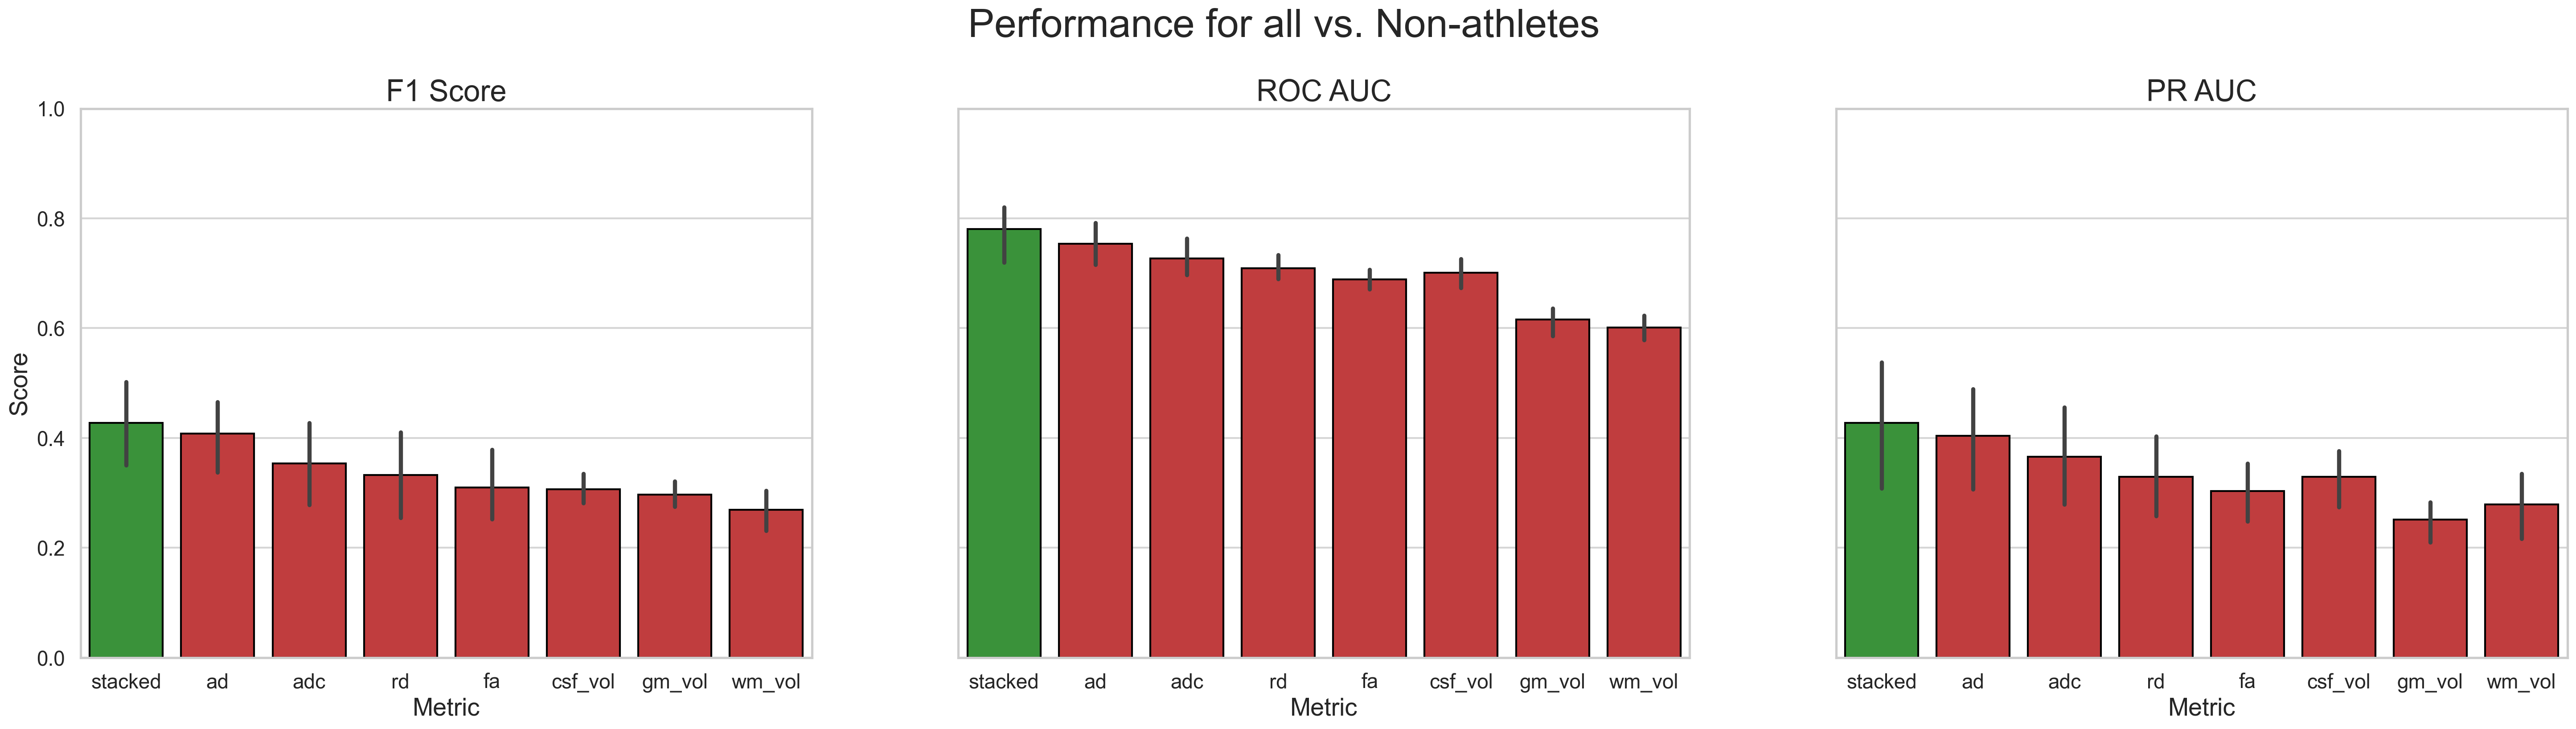

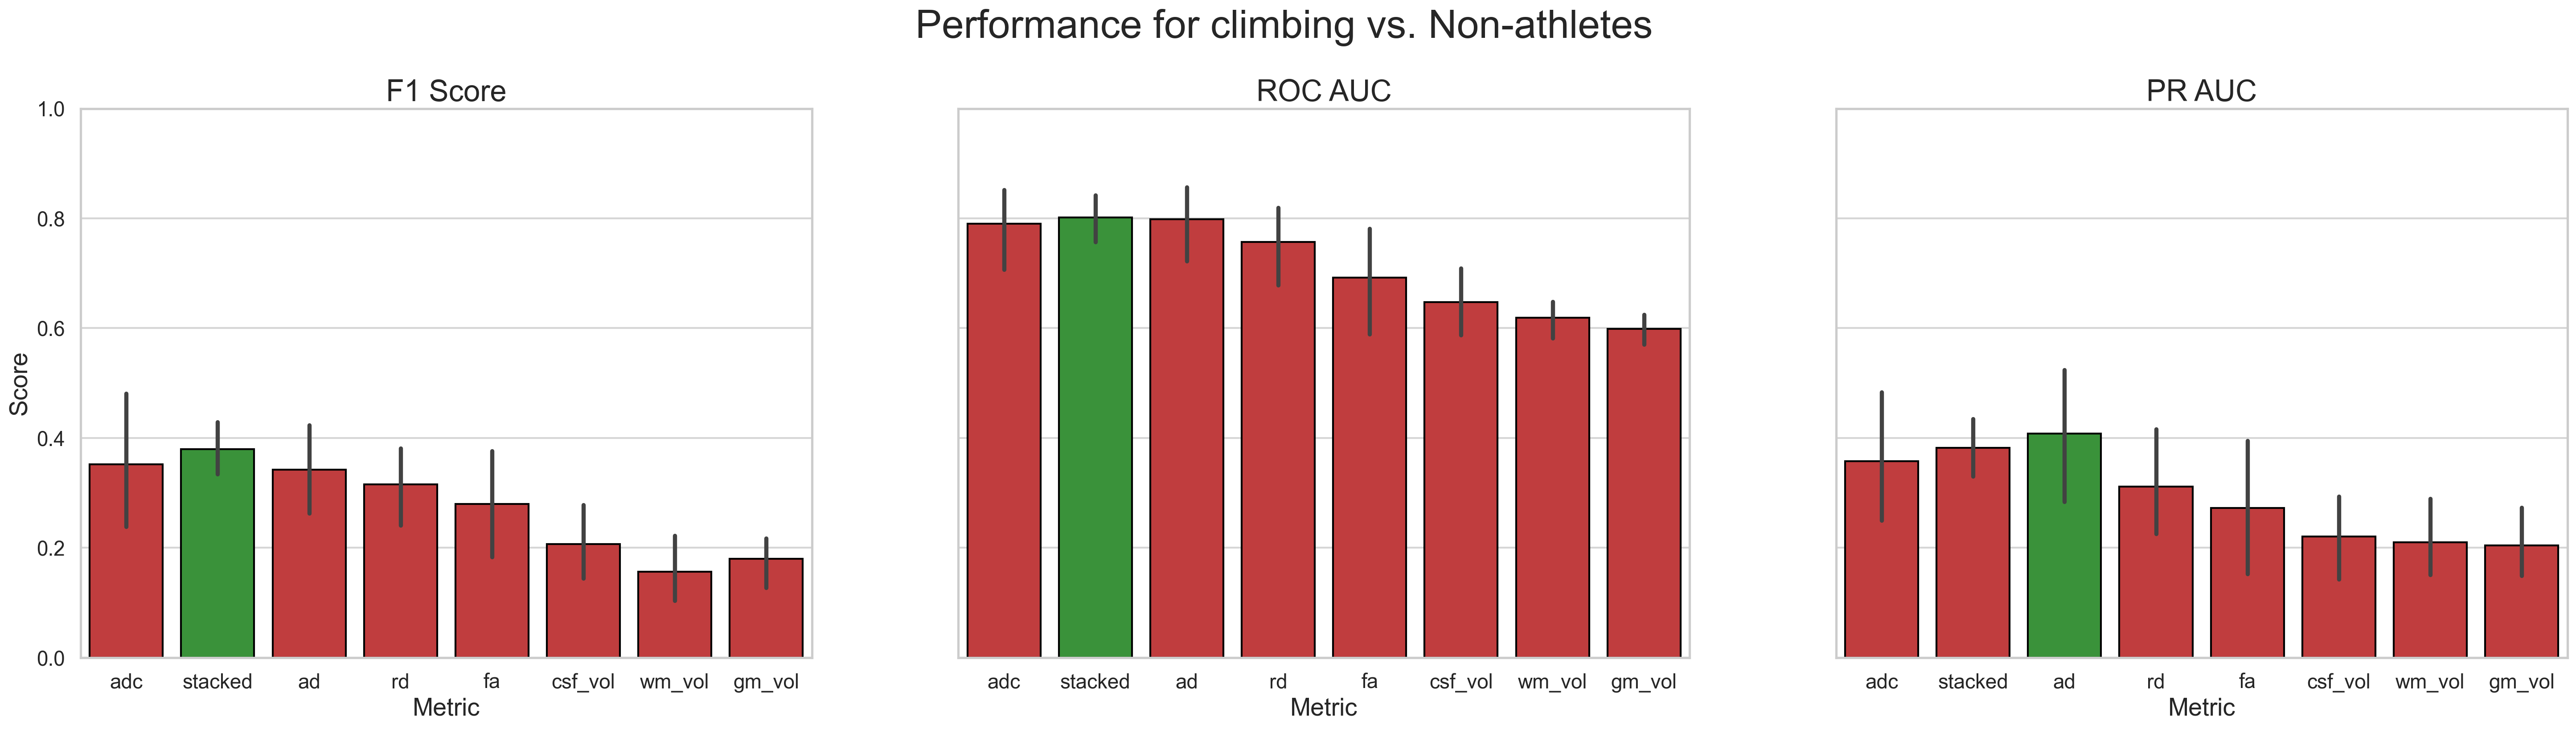

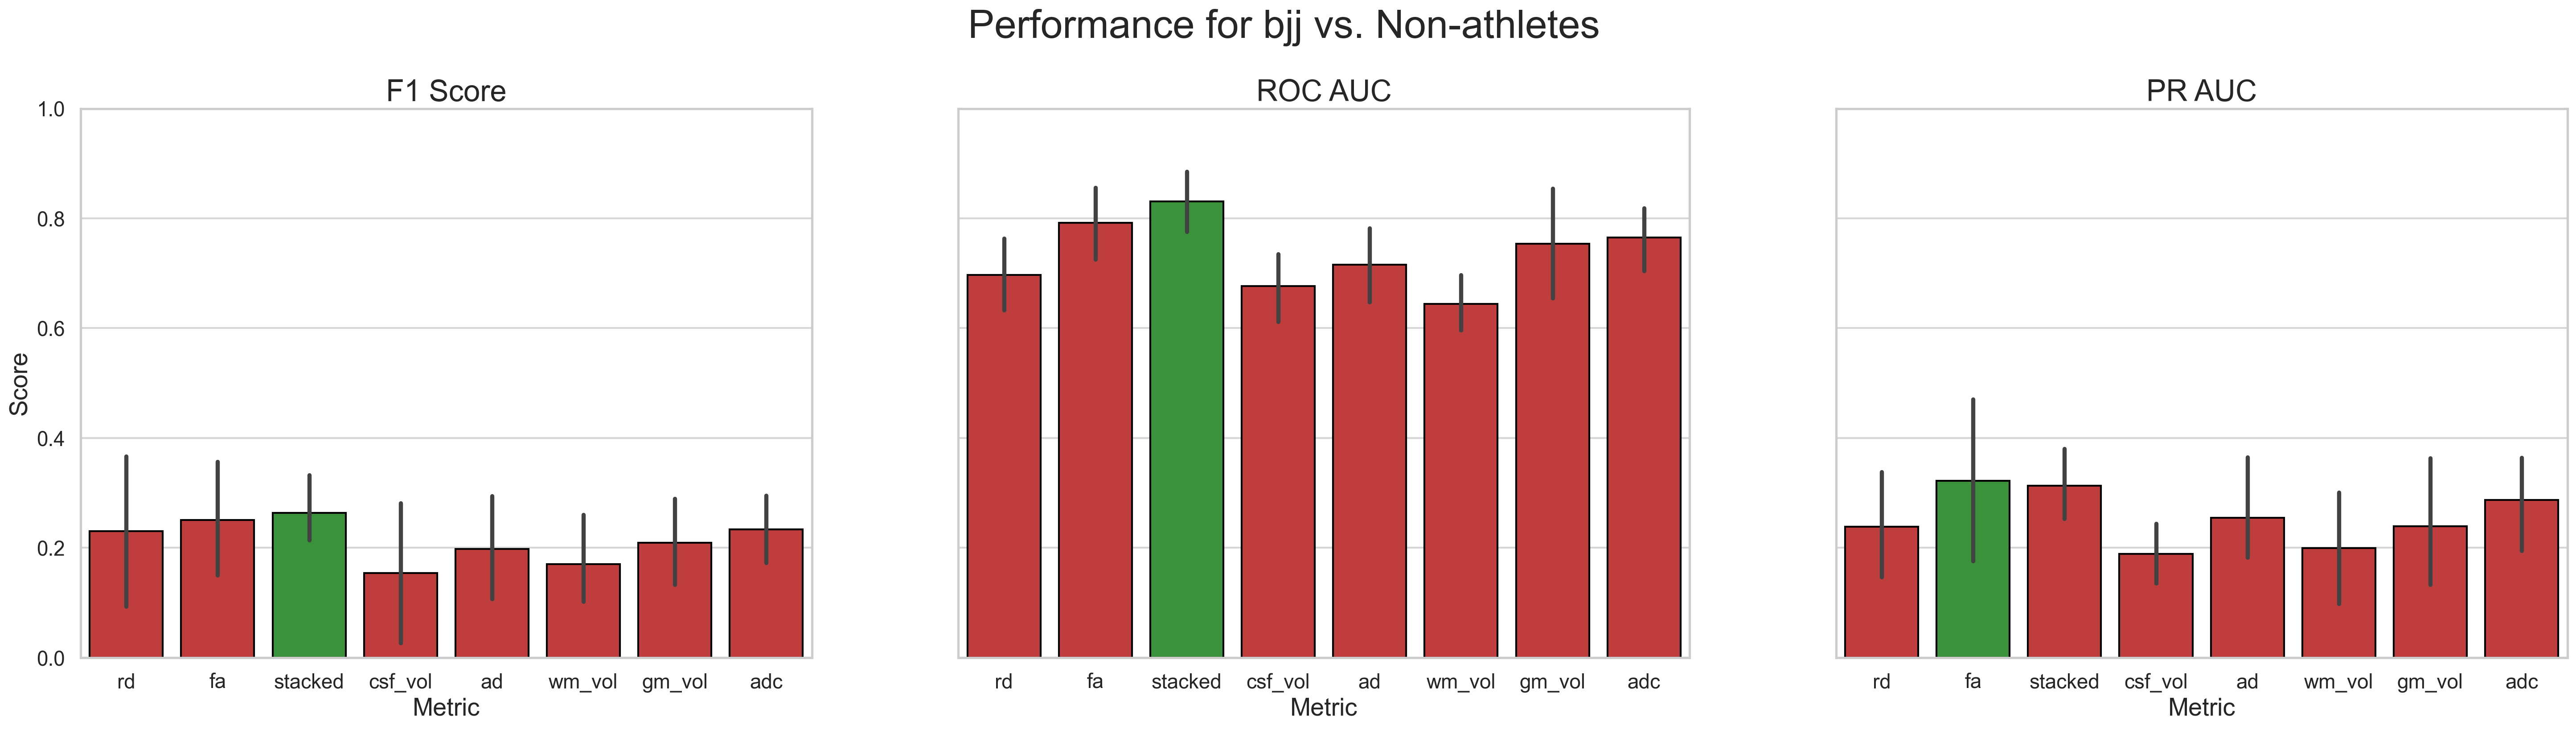

In [284]:
scorers = ["average_precision", "roc_auc", "f1"]
scorers = {
    "f1": "F1 Score",
    "roc_auc": "ROC AUC",
    "average_precision": "PR AUC",
}

for i, (group_name, group_data) in enumerate(results.items()):

    fig, axes = plt.subplots(
        nrows=1, ncols=len(scorers), figsize=(12 * len(scorers), 8), sharex=True, sharey=True
    )
    fig.suptitle(
        f"Performance for {group_name} vs. Non-athletes", fontsize=32, y=1.02
    )
    for j, (scorer, scorer_title) in enumerate(scorers.items()):
        ax = axes[j] if len(scorers) > 1 else axes
        # if i == 0:
        ax.set_title(scorer_title, fontsize=24)
        if j == 0:
            ax.set_ylabel(group_name, fontsize=24)
        # Filter the results for the current scorer
        vis_df = pd.DataFrame()
        for color, (metric, result_df) in enumerate(group_data.items()):
            # Filter out empty DataFrames
            if result_df.empty:
                continue
            result_df = result_df.loc[scorer,["score"]]
            result_df["metric"] = metric
            vis_df = pd.concat([vis_df, result_df], axis=0)
        # sort vis_df by average score
        vis_df = vis_df.sort_values(by="score", ascending=False).reset_index()
        # select the best metric
        v = vis_df.groupby("metric")["score"].mean().idxmax()
        vis_df["best"] = vis_df["metric"] == v
        # Plot the results
        sns.barplot(
            data=vis_df,
            x="metric",
            y="score",
            ax=ax,
            hue="best",
            hue_order=[True, False],
            palette=["#2ca02c", "#d62728"],  # green for best
            edgecolor="black",
        )
        # don't show legend
        ax.get_legend().remove()
        ax.set_xlabel("Metric", fontsize=20)
        ax.set_ylabel("Score", fontsize=20)
        ax.set_ylim(0, 1)

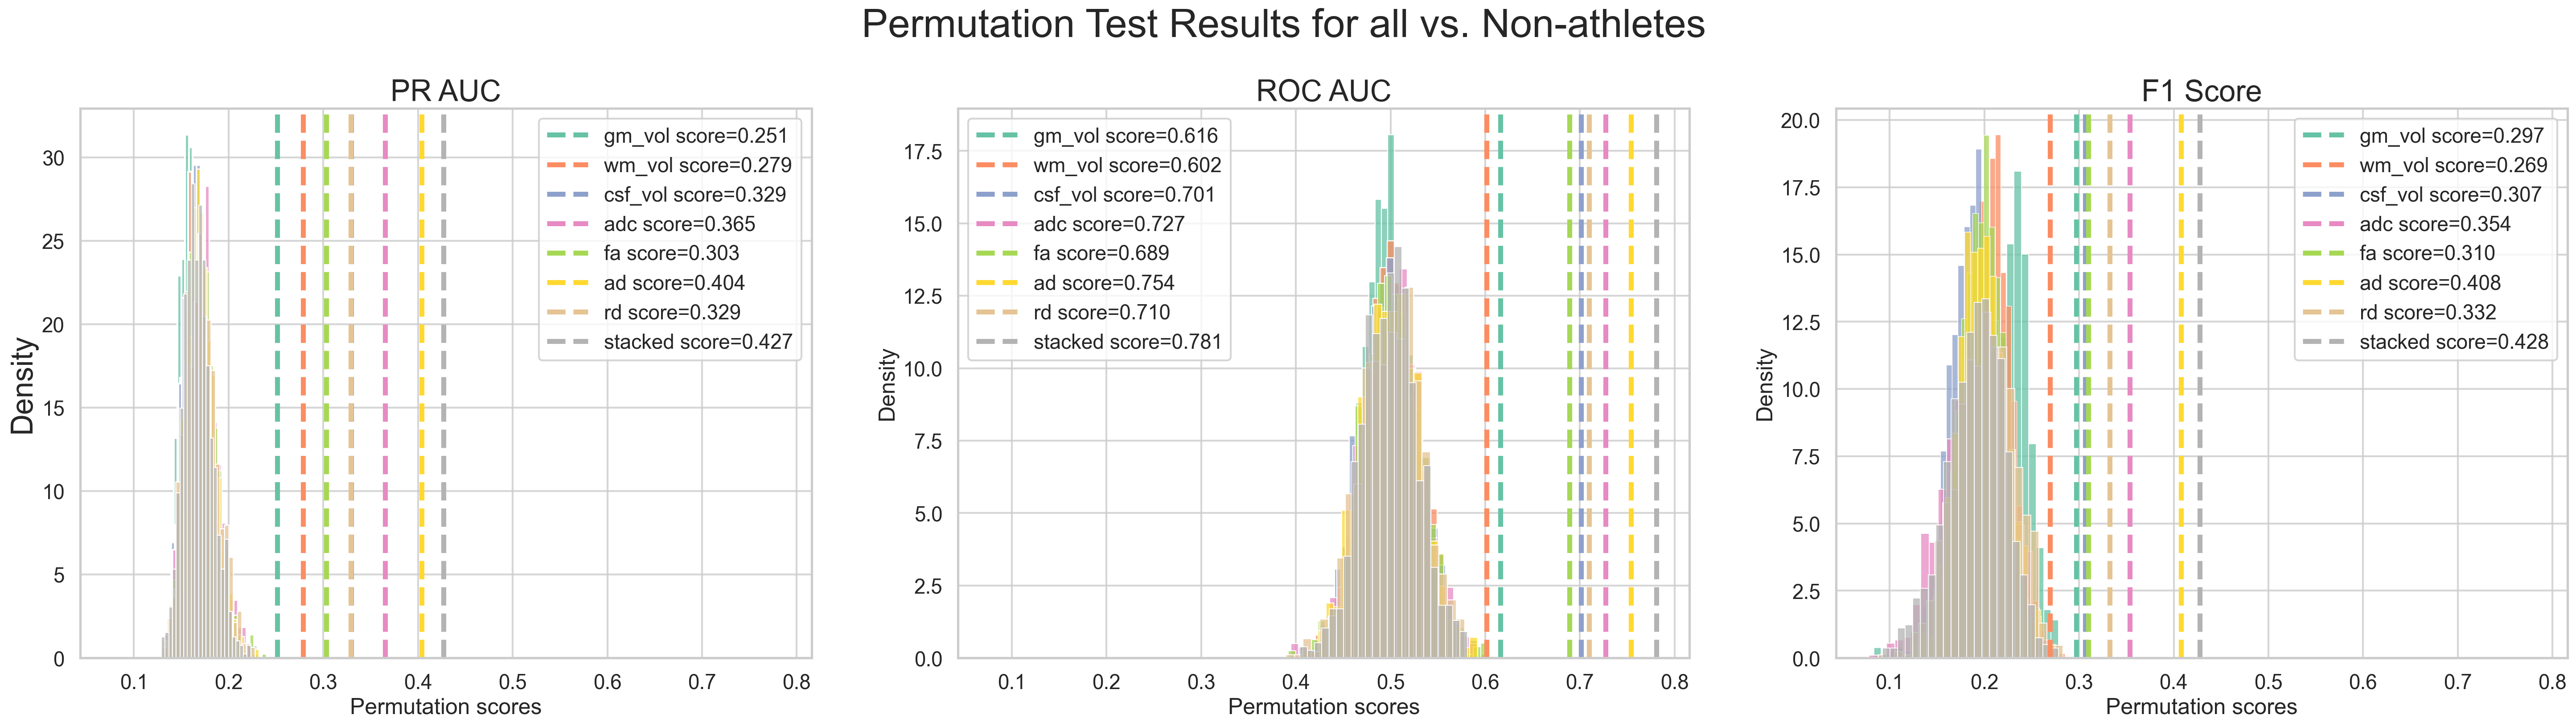

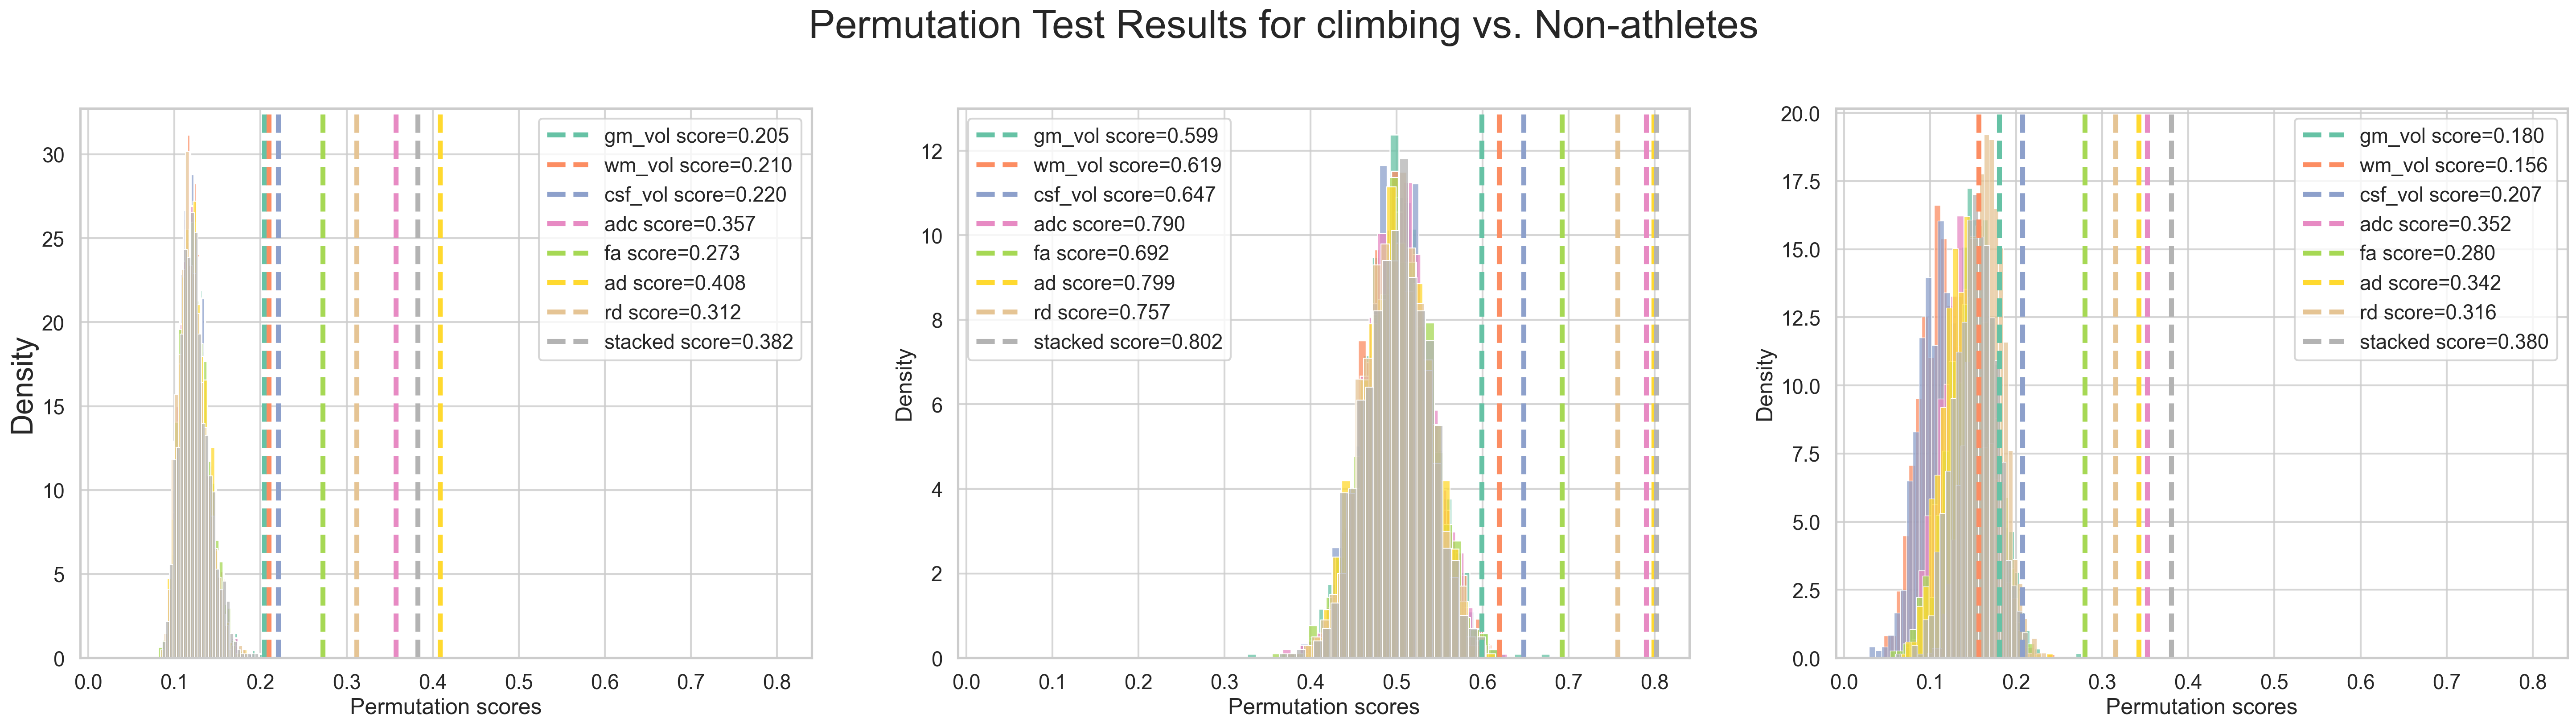

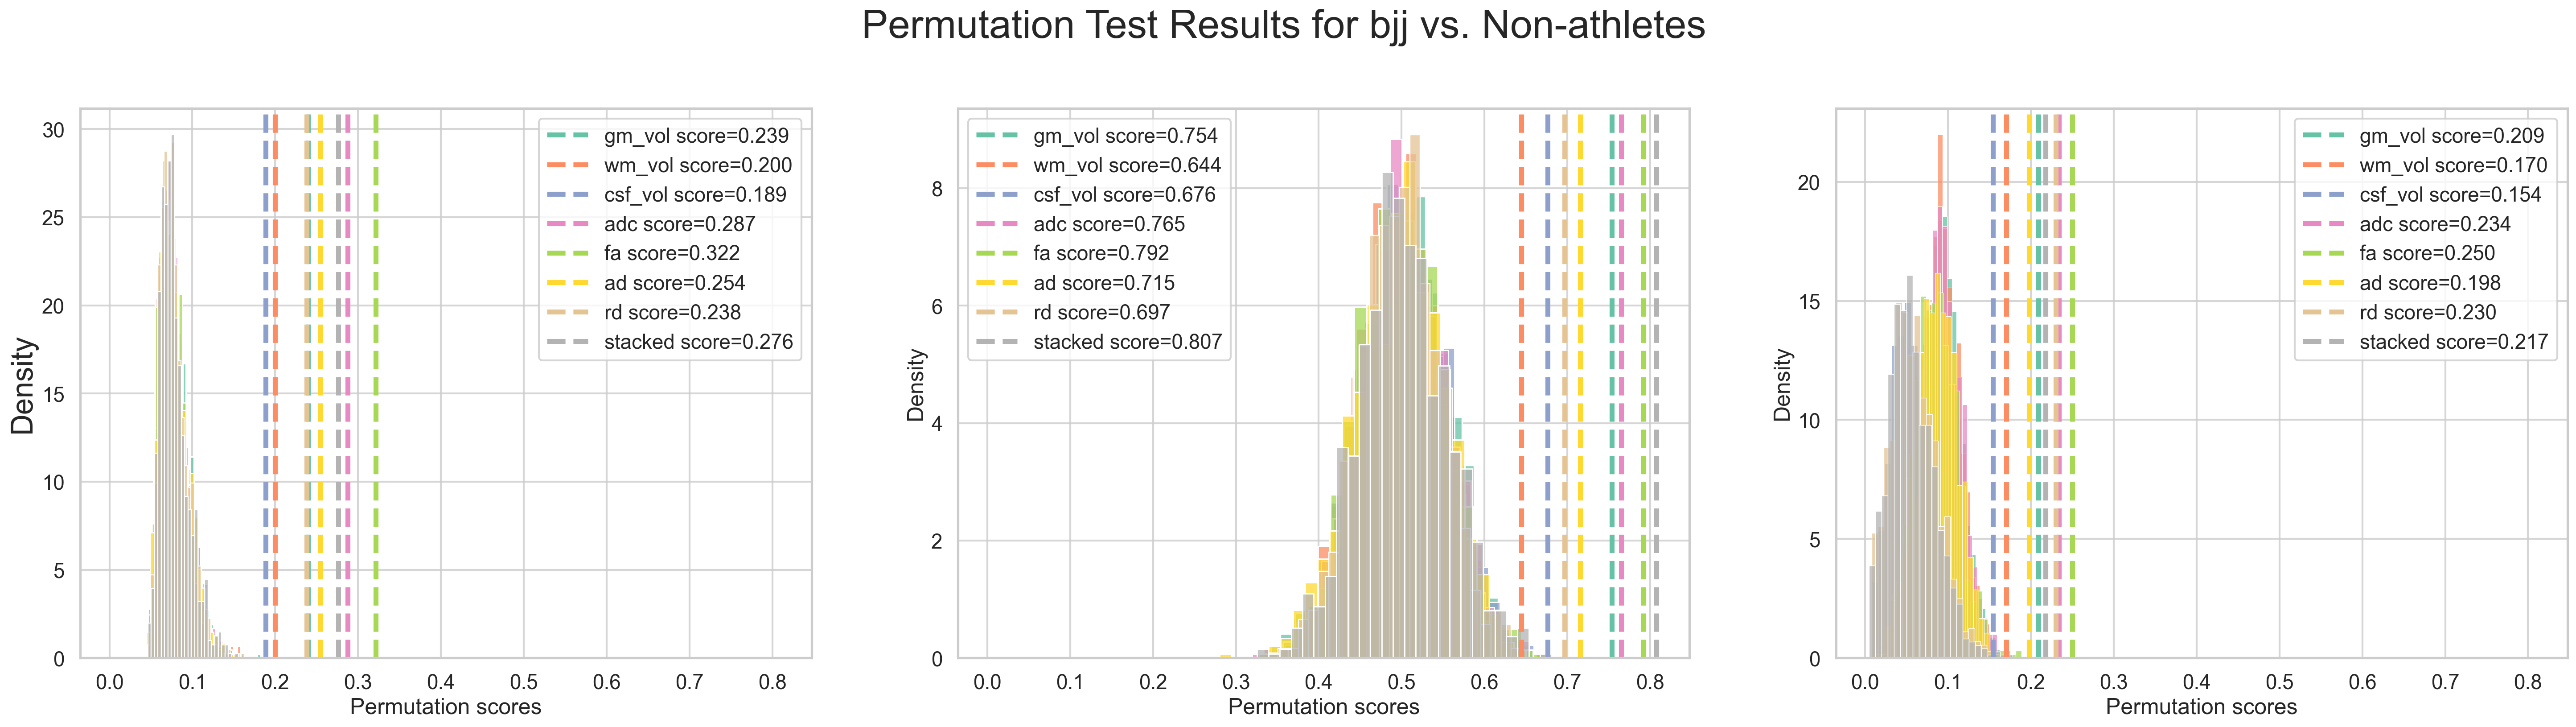

In [145]:
for i, (group_name, group_data) in enumerate(results.items()):

    fig, axes = plt.subplots(nrows=1, ncols=len(scorers), figsize=(12* len(scorers), 8), sharex=True)
    fig.suptitle(f"Permutation Test Results for {group_name} vs. Non-athletes", fontsize=32, y=1.02)
    for j, (scorer, scorer_title) in enumerate(scorers.items()):
        ax = axes[j] if len(scorers) > 1 else axes
        if i == 0:
            ax.set_title(scorer_title, fontsize=24)
        if j == 0:
            ax.set_ylabel(group_name, fontsize=24)
        # Filter the results for the current scorer
        for color, (metric, result_df) in enumerate(group_data.items()):
            # Filter out empty DataFrames
            if result_df.empty:
                continue
            result_df = result_df.loc[scorer]
            permutations = result_df["permutation_scores"].iloc[0]
            permutations = permutations[permutations != 0]  # Remove zeros if any
            score = result_df["permutation_score"].iloc[0]
            pvalue = result_df["pvalue"].iloc[0]
            # Plot the results
            _ = sns.histplot(
                permutations,
                ax=ax,
                # kde=True,
                stat="density",
                color=sns.color_palette("Set2")[color],
            )
            ax.axvline(score, color=sns.color_palette("Set2")[color], linestyle="--", lw=4, label=f"{metric} score={score:.3f}")
        
        ax.set_xlabel("Permutation scores")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True)

        # break
    # break

In [146]:
def roi_results_to_long_format(
    df_wide: pd.DataFrame,
    id_vars: list = None,
    value_vars_prefix: list = None,
    var_name: str = "metric_fold",
    value_name: str = "score",
) -> pd.DataFrame:
    """
    Transforms a wide-format ROI results DataFrame (e.g., from stacked_models_results)
    into a long format.

    Parameters
    ----------
    df_wide : pd.DataFrame
        The input DataFrame in wide format with 'scorer-fold' columns.
    id_vars : list, optional
        A list of column names that should remain as ID variables.
        If None, it defaults to common descriptive columns for ROIs.
    value_vars_prefix : list, optional
        A list of prefixes for the value columns (e.g., ['average_precision', 'roc_auc', 'f1']).
        If None, it tries to infer from common scoring metrics.
    var_name : str, optional
        Name for the new column that will store the 'scorer-fold' identifiers.
        Defaults to 'metric_fold'.
    value_name : str, optional
        Name for the new column that will store the scores.
        Defaults to 'score'.

    Returns
    -------
    pd.DataFrame
        The DataFrame in long format.
    """
    if id_vars is None:
        id_vars = ["name", "base_name", "Label Name", "network", "component", "hemisphere"]

    if value_vars_prefix is None:
        value_vars_prefix = ["average_precision", "roc_auc", "f1"]

    # Identify the columns that contain the scores to be unpivoted
    score_columns = [
        col
        for col in df_wide.columns
        if any(col.startswith(prefix) for prefix in value_vars_prefix)
    ]

    # Use pd.melt to unpivot the DataFrame
    df_long = pd.melt(
        df_wide,
        id_vars=id_vars,
        value_vars=score_columns,
        var_name=var_name,
        value_name=value_name,
    )

    # Further split the 'metric_fold' column into 'metric' and 'fold'
    df_long[["metric", "fold"]] = df_long["metric_fold"].str.rsplit("-", n=1, expand=True)
    df_long["fold"] = pd.to_numeric(df_long["fold"])  # Convert fold to numeric if needed

    # Drop the original 'metric_fold' column if it's no longer needed
    df_long = df_long.drop(columns=[var_name])

    return df_long

In [170]:
# load roi-specific predictions
stacked_results = {}
for group, group_name in GROUP_NAMES.items():
    stacked_file = OUTPUT_DIR / group_name / "stacked" / "roi_results.csv"
    if not stacked_file.exists():
        print(f"No stacked file found for {group_name}, skipping.")
        continue

    stacked_results[group_name] = roi_results_to_long_format(pd.read_csv(
        stacked_file, index_col=0
    ))

# load roi predictions to do model inspection

for group_name in stacked_results:
    X = pd.read_csv(OUTPUT_DIR / group_name / "stacked" / "X.csv")
    y = pd.read_csv(OUTPUT_DIR / group_name / "stacked" / "y.csv")
    break

In [220]:
# Model inspection using SHAP values
import shap

# We use a pipeline, so we need to extract the model from the pipeline
group_name = "all"
stacked_estimator = best_models[group_name]["stacked"]
preprocessor, imputer, estimator = (stacked_estimator.named_steps[key] for key in ["preprocessor", "imputer", "classifier"])

# Prepare the data for SHAP
X_stacked = X.copy().astype(float)  # Ensure all data is float for SHAP
X_stacked.columns = X_stacked.columns.astype(str)
X_stacked["sex"] = X_stacked["sex"].astype(int)  # Ensure sex is int for SHAP

X_stacked = preprocessor.fit_transform(X_stacked)
X_stacked = imputer.transform(X_stacked)
X_stacked = pd.DataFrame(X_stacked, columns=preprocessor.get_feature_names_out())
# Create a SHAP explainer
explainer = shap.explainers.Linear(
    estimator, X_stacked, feature_names=X_stacked.columns
)

In [221]:
explanation = explainer(X_stacked)  # Use a subset of samples for faster computation

In [245]:
importances = parcels.copy()
importances["shap_value"] = explanation[:,:len(parcels)].values.mean(axis=0)
# sort by absolute SHAP value
importances["abs_shap_value"] = importances["shap_value"].abs()
importances.sort_values(by="abs_shap_value", ascending=False)

,index,name,base_name,Label Name,network,component,hemisphere,shap_value,abs_shap_value
61,62,7Networks_LH_SomMot_31,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,0.016452,0.016452
258,259,7Networks_RH_SomMot_29,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,0.011784,0.011784
217,218,7Networks_RH_Vis_18,7networks_rh_vis,7Networks_RH_Vis,visual,visual,R,0.010347,0.010347
403,404,THA-VAia-rh,THA-VAia,"Thalamus, inferior ventro-anterior part, anter...",subcortex,Thalamus,R,0.009590,0.009590
14,15,7Networks_LH_Vis_15,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.008183,0.008183
...,...,...,...,...,...,...,...,...,...
34,35,7Networks_LH_SomMot_4,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,0.000021,0.000021
273,274,7Networks_RH_DorsAttn_Post_4,7networks_rh_dorsattn_post,7Networks_RH_DorsAttn_Post,dorsal attention,posterior,R,0.000015,0.000015
97,98,7Networks_LH_SalVentAttn_FrOperIns_2,7networks_lh_salventattn_froperins,7Networks_LH_SalVentAttn_FrOperIns,salience / ventral attention,frontal operculum insula,L,0.000007,0.000007
433,434,HIP-tail-lh,HIP-tail,Hippocampus tail,subcortex,Hippocampus tail,L,-0.000004,0.000004


In [ ]:
# do permutation importance
from sklearn.inspection import permutation_importance
# Calculate permutation importance
perm_importance = permutation_importance(
    stacked_estimator, X, y["target"], n_repeats=30, random_state=42, n_jobs=-1
)


In [251]:
# Create a DataFrame for permutation importance
importances["permutation_importance"] = perm_importance.importances_mean[: len(parcels)]
importances["permutation_importance_std"] = perm_importance.importances_std[: len(parcels)]

In [278]:
from nilearn import plotting

atlas_img = nib.load(nifti_matlab)
atlas_data = np.round(atlas_img.get_fdata())


for i, row in importances.iterrows():
    region_id = row[region_col]
    # Find the index of the region in the atlas data
    region_mask = atlas_data == region_id
    atlas_data[region_mask] = row["shap_value"]

atlas_data[atlas_data< 0] = 0  # Set negative values to zero for better visualization
# Save the modified atlas data with SHAP values
atlas_img_with_shap = nib.Nifti1Image(atlas_data, atlas_img.affine, atlas_img.header)

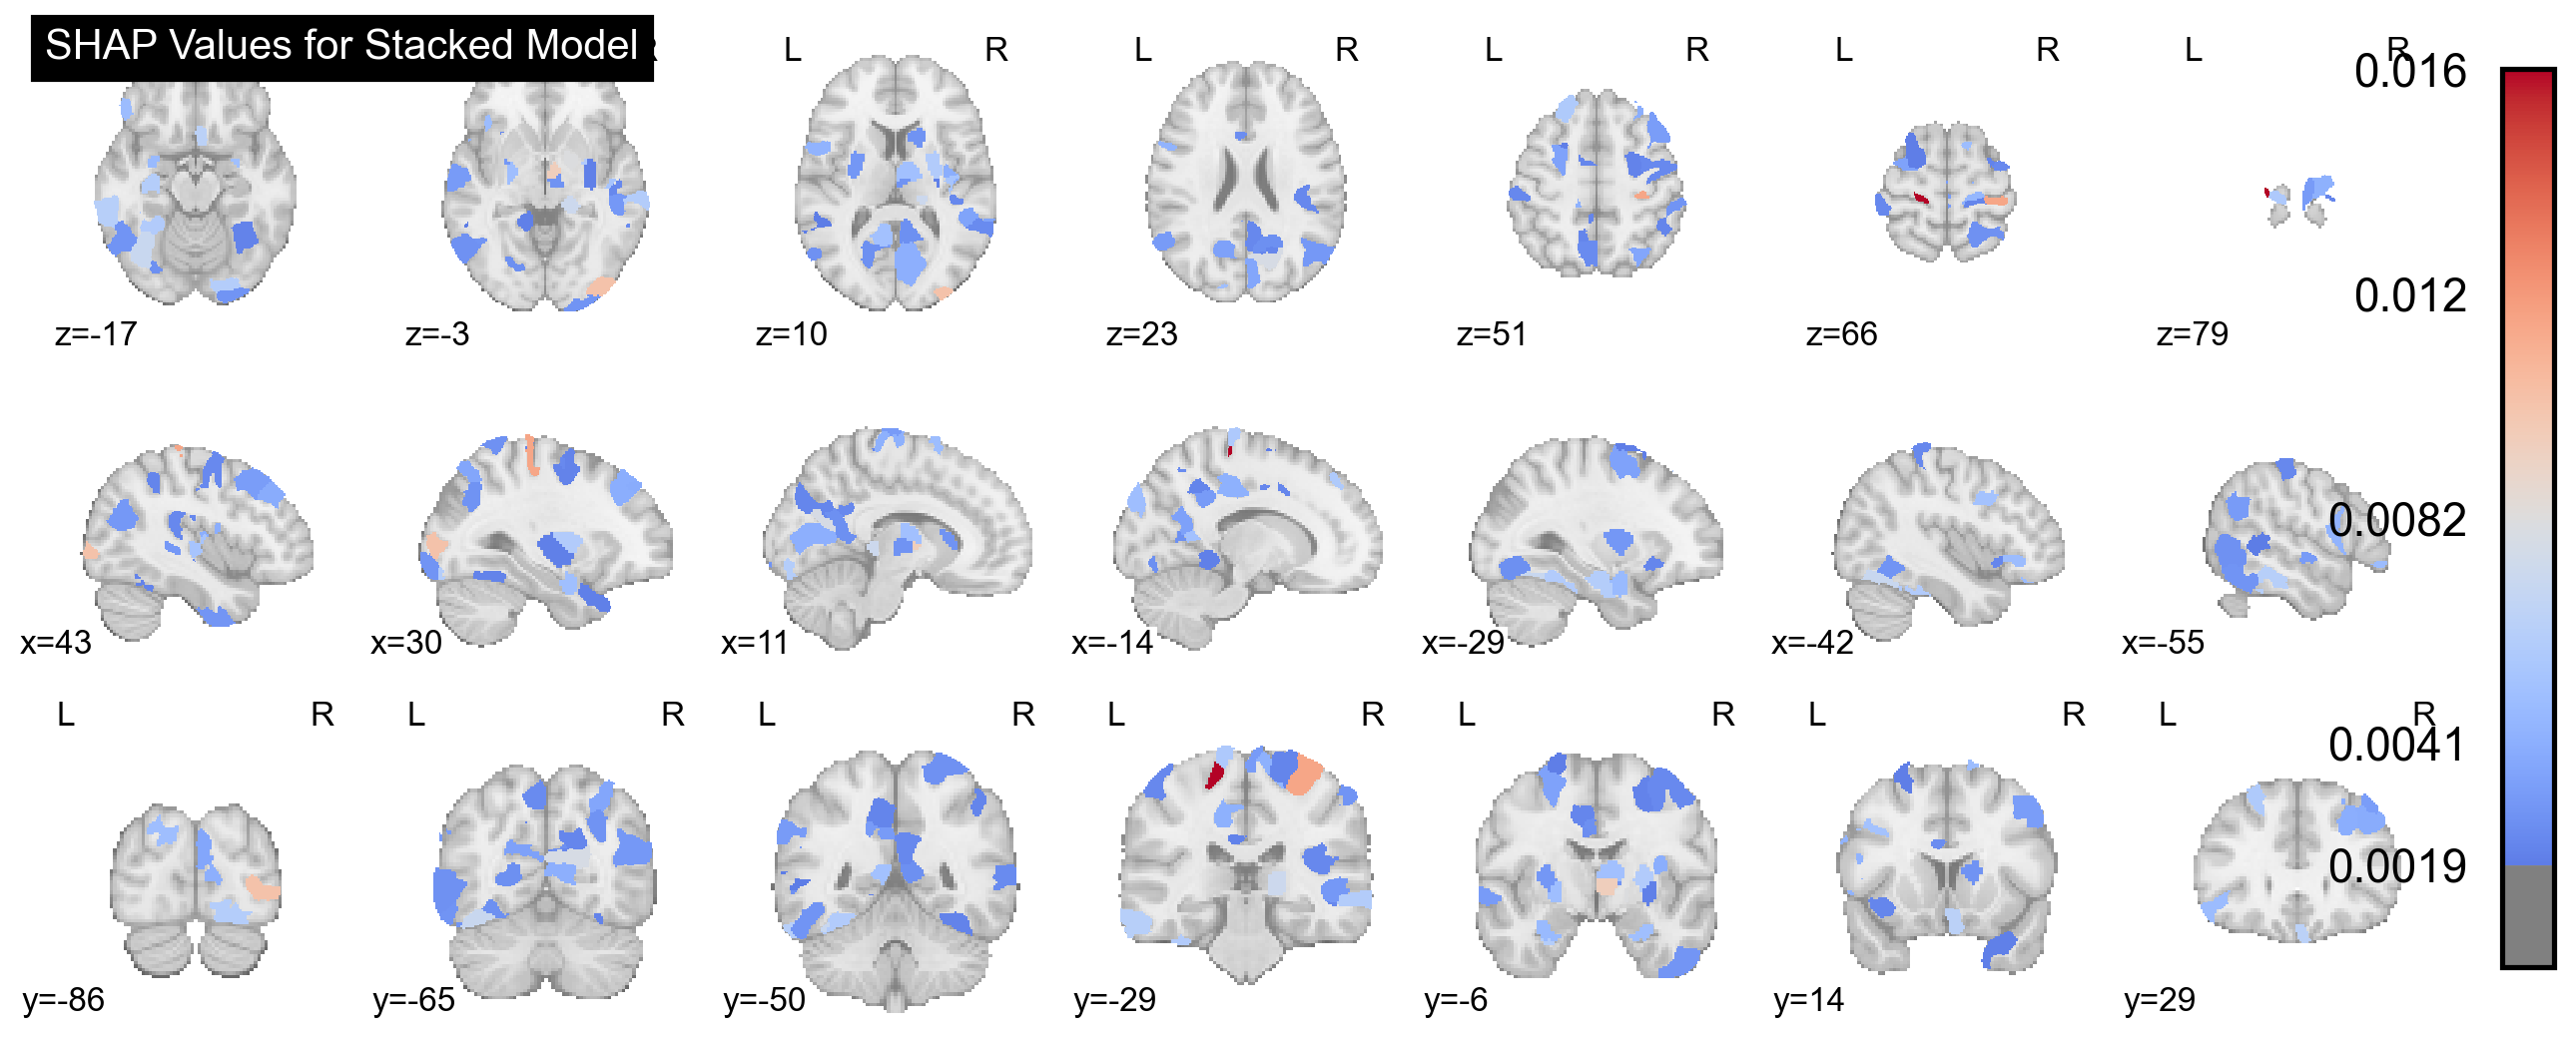

In [280]:
plotting.plot_stat_map(
    atlas_img_with_shap,
    title="SHAP Values for Stacked Model",
    display_mode="mosaic",
    # cut_coords=(0, 0, 0),
    threshold=importances["shap_value"].abs().mean(),
    colorbar=True,
    cmap="coolwarm",
)

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [ ]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region": [], "value": [], "Hemisphere": []}

key = "gm_vol"  # or any other metric you want to visualize


# vis_df = athletes_vs_naive_results[key].copy()
vis_df = sports_vs_naive_results[climber_group_label][
    key
].copy()  # or climbers_vs_bjj_results[key].copy()
p_column = "adjusted_p_value"
value_column = "t_statistic"

value_map_lh = {}  # New: separate map for left hemisphere
value_map_rh = {}  # New: separate map for right hemisphere

for i, row in vis_df.iterrows():
    label = row[region_col]
    hemi_row = row["hemisphere"]  # Get hemisphere from your DataFrame row

    # Apply thresholds
    if (row[p_column] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
        value = row[value_column]
    else:
        value = np.nan  # Set to NaN if not significant or below value_threshold

    # Populate the correct hemisphere's value_map
    # Assuming your labels are global and you use the 'hemisphere' column to distinguish
    # If your Schaefer labels are already separated by hemi (e.g., 1-200 for LH, 201-400 for RH)
    # then you might only need to check the label range and not the 'hemisphere' column.
    # For Schaefer, the labels usually run 1-N for LH and N+1 - 2N for RH
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            if hemi_row == "L":
                value_map_lh[label] = value
            elif hemi_row == "R":
                value_map_rh[label] = value
        # Subcortex handling would go here if you were preparing for separate subcortical visualization
        # else: # This implies it's subcortical or other non-surface region
        #     value_map_subcortex["region"].append(label)
        #     value_map_subcortex["value"].append(value)
        #     value_map_subcortex["Hemisphere"].append(row["hemisphere"])

# Vectorize mapping for left and right hemispheres separately
vec_lh = np.vectorize(lambda x: value_map_lh.get(x, np.nan))
data_lh_mapped = vec_lh(lh_parc)  # Apply LH map to LH parcellation
vec_rh = np.vectorize(lambda x: value_map_rh.get(x, np.nan))
data_rh_mapped = vec_rh(rh_parc)  # Apply RH map to RH parcellation

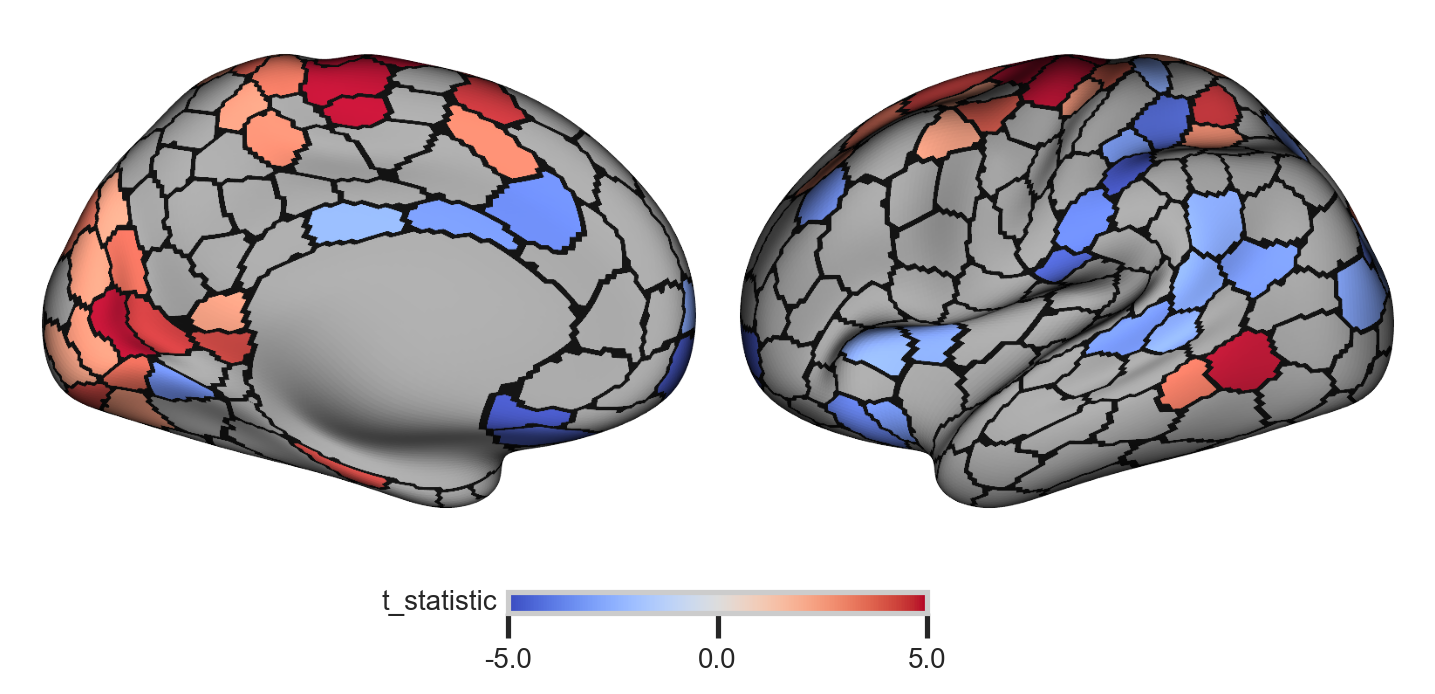

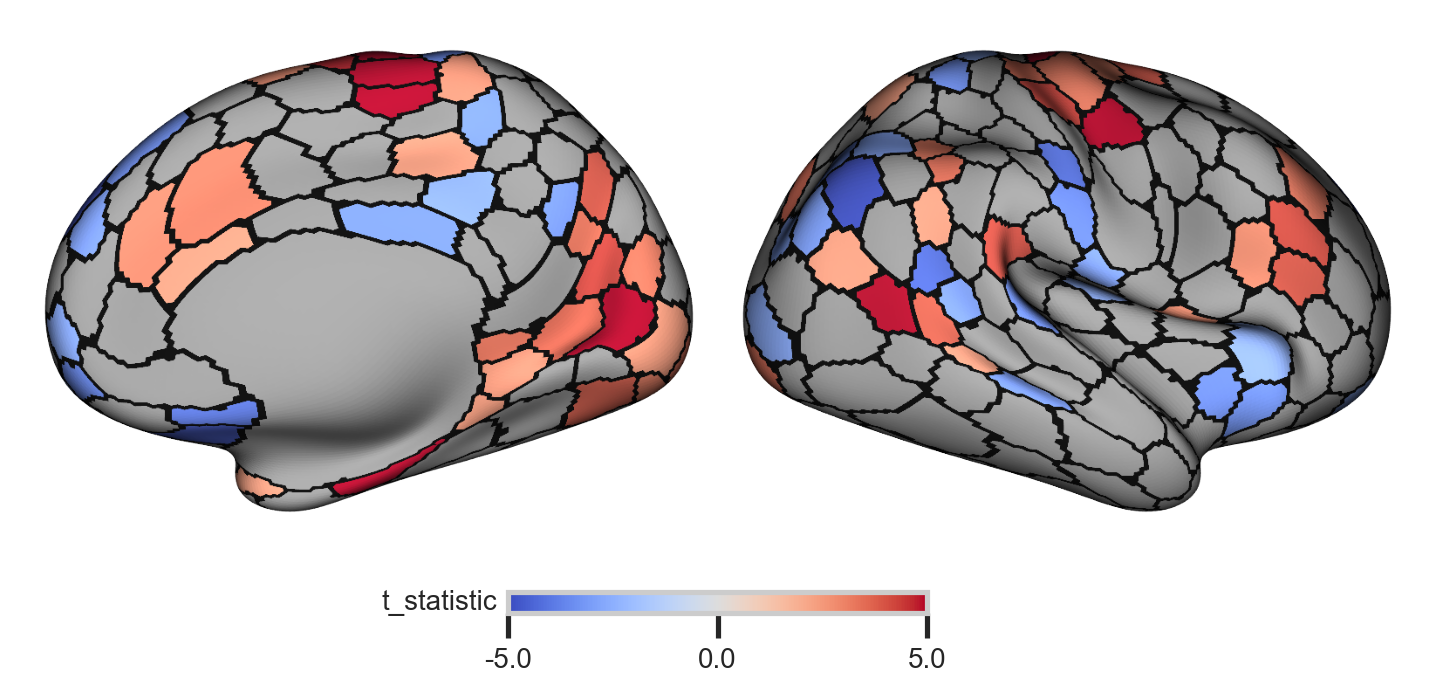

In [ ]:
vmin = -5
vmax = 5

# Corrected loop for plotting each hemisphere independently
for hemi_key, hemi_surf_data, mapped_data, parcellation_data in zip(
    ["left", "right"],  # The key for surfplot's dictionary
    [lh, rh],  # The surface object for the current hemisphere
    [data_lh_mapped, data_rh_mapped],  # The mapped data for the current hemisphere
    [lh_parc, rh_parc],  # The parcellation for the current hemisphere
):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    pref_surf = {
        "surf_lh": hemi_surf_data if hemi_key == "left" else None,
        "surf_rh": hemi_surf_data if hemi_key == "right" else None,
    }
    p = Plot(
        **pref_surf,  # Unpack the surface dictionary
        views=["medial", "lateral"],  # Show both medial and lateral for this hemi
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",  # For a single hemisphere, row is fine
        mirror_views=False,  # Set to False, as we are plotting one hemi at a time
    )

    # ---- main data layer -------------------------------------------------
    # Pass only the data for the current hemisphere
    # The dictionary now contains only one key-value pair for the current hemisphere
    p.add_layer(
        {hemi_key: mapped_data},
        cmap="coolwarm",
        color_range=(vmin, vmax),  # Use symmetric range
        # norm=norm,  # Apply the symmetric normalization
        cbar_label=value_column,
        cbar=True,  # Ensure colorbar is shown for each plot if desired, or handle globally
    )
    # ---- outline layer ---------------------------------------------------
    p.add_layer({hemi_key: parcellation_data}, cmap="gray", as_outline=True, cbar=False)

    fig = p.build(
        # cbar_kws=dict(location="bottom", decimals=2, shrink=0.6)
    )  # Added cbar_kws for better cbar display

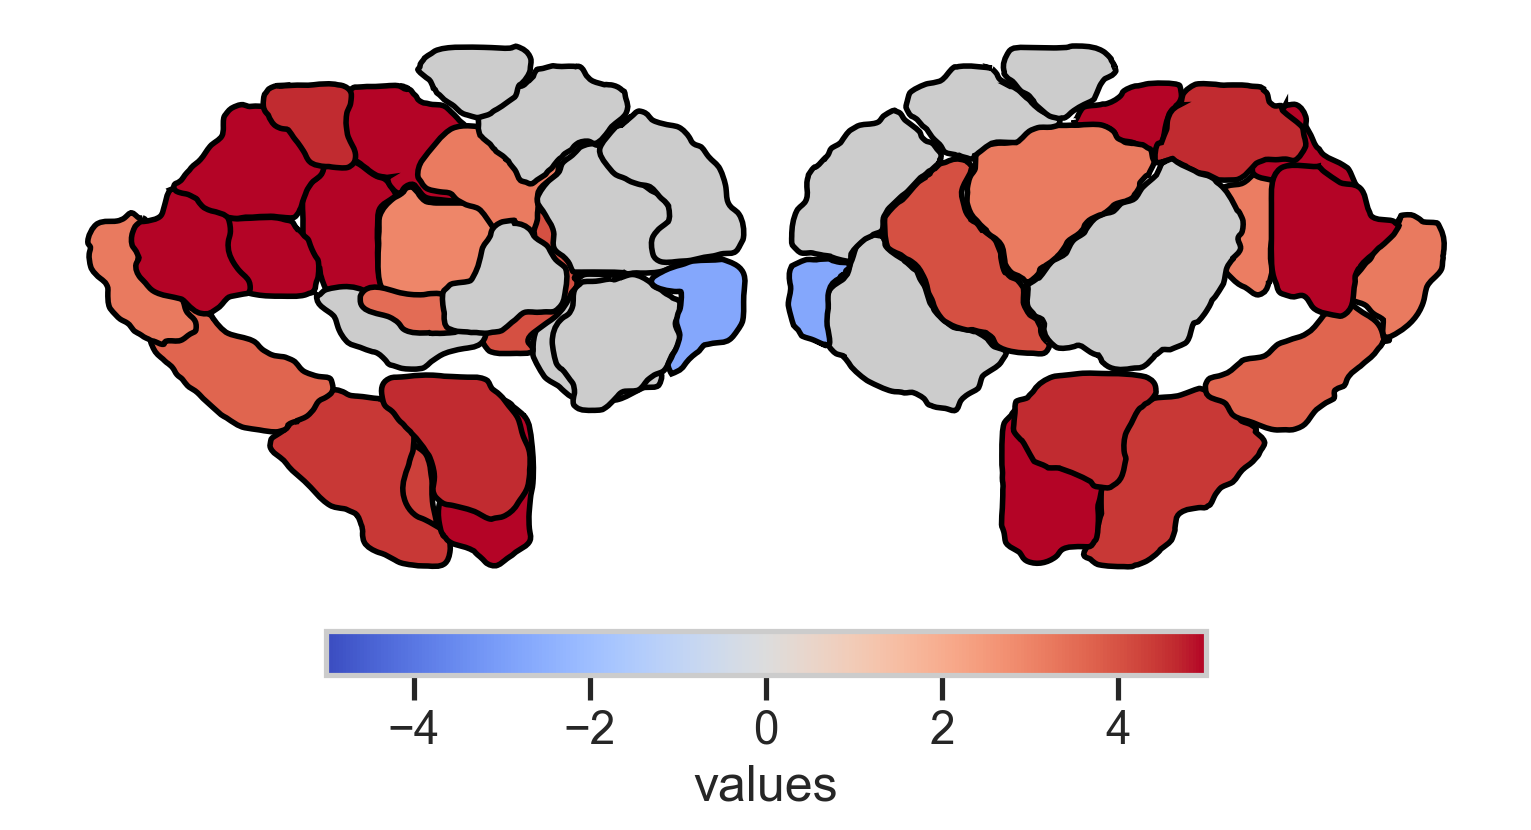

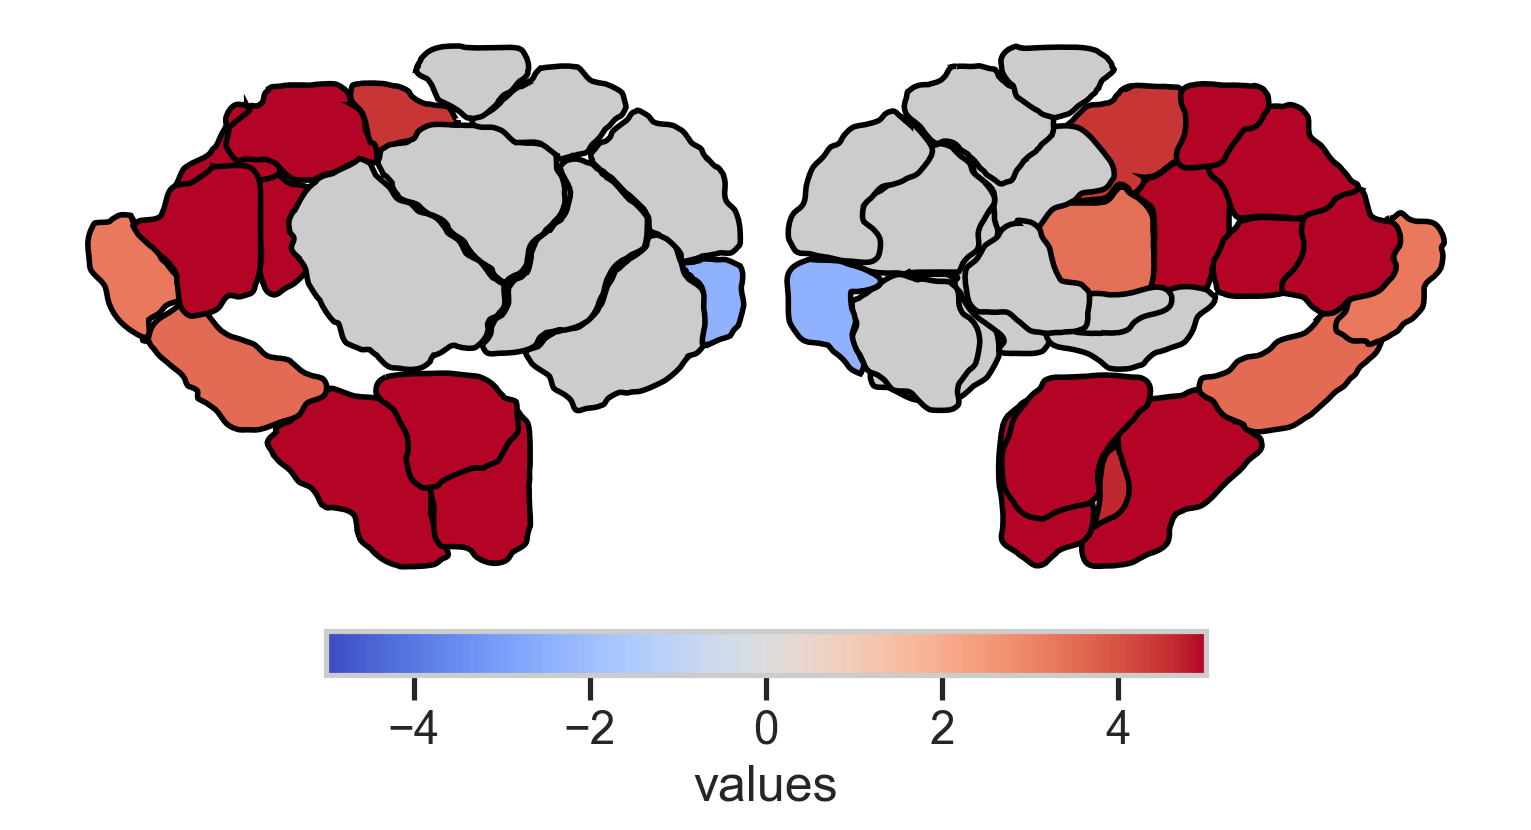

In [ ]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L", "R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="coolwarm",
        line_color="black",
        line_thickness=2,
        vmin=vmin,
        vmax=vmax,
        show_figure=False,
    )

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)